In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotnine import *
import itertools
from nilearn import image, plotting, datasets, masking
import nibabel as nib
import pdb
import os
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template

In [10]:
study='hemispace'

patient_dir = f"/lab_data/behrmannlab/vlad/{study}"

control_dir = f"/lab_data/behrmannlab/vlad/hemispace"
suf = '_roi'
exps = ['spaceloc','toolloc']
copes = [1,1]
p_hemi = ['right', 'left','right'] #the remaining hemi of the sub
c_hemi = ['left', 'right']

c_subs =["spaceloc1001", "spaceloc1002", "spaceloc1003", "spaceloc1004", "spaceloc1005", "spaceloc1006", "spaceloc1007",
"spaceloc1008" ,"spaceloc1009", "spaceloc1010", "spaceloc1011" ,"spaceloc1012",
"spaceloc2013","spaceloc2014","spaceloc2015","spaceloc2016" ]

c_subs =["hemispace2001", "hemispace2002", "hemispace2003"]

p_subs = ['hemispace1001','hemispace1002','hemispace1003']

#left is negative, right is positive
mni = load_mni152_brain_mask()
mni_affine = mni.affine

In [10]:
for ss in enumerate(p_subs):
#exp = 


    sub_dir = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/'
    #stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

    #load anat
    anat_mask = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask.nii.gz')
    anat = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain.nii.gz')
    anat = image.get_data(anat)
    affine = anat_mask.affine
    hemi_mask = image.get_data(anat_mask)

    #extract just one hemi
    mid = list((np.array((hemi_mask.shape))/2).astype(int)) #find mid point of image

    hemi_mask[hemi_mask>0] = 1 #ensure to mask all of it

    if p_hemi[ss[0]] == 'left':
        hemi_mask[mid[0]:, :, :] = 0 
    else:
        hemi_mask[:mid[0], :, :] = 0 

    anat_flip = anat
    anat_mirror = anat
    anat_flip =anat_flip[::-1,:, :]

    anat_mirror[:mid[0],:,:] = anat_flip[:mid[0],:,:]

    anat_mirror = nib.Nifti1Image(anat_mirror, affine)  # create the volume image
    nib.save(anat_mirror,f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-hemispace1001_ses-01_T1w_brain_mirrored.nii.gz')

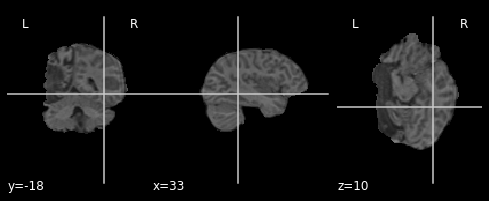

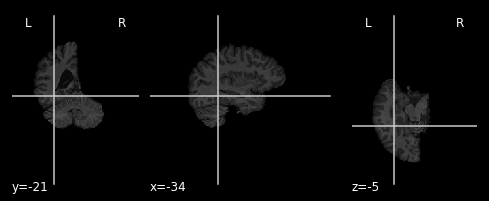

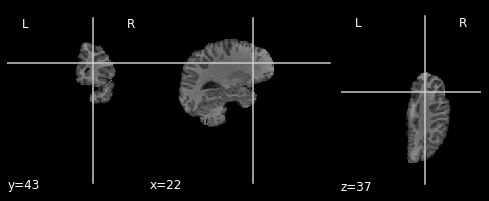

In [8]:
for ss in enumerate(p_subs):
#exp = 


    sub_dir = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/'
    #stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

    #load anat
    anat_mask = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask.nii.gz')
    anat = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain.nii.gz')

    plotting.plot_anat(anat)
    plt.pause(.001)

In [23]:
#load hemisubj
control_summary = pd.DataFrame(columns=[['l' + exp for exp in exps] + ['r' + exp for exp in exps]])
patient_summary = pd.DataFrame(columns=exps)

for exp in enumerate(exps):

    '''
    Extract activation spread from patients
    '''
    p_acts = []
    for ss in enumerate(p_subs):
        #set up dirs
        sub_dir = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/'
        stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

        #load anat
        anat_mask = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask.nii.gz')
        affine = anat_mask.affine
        hemi_mask = image.get_data(anat_mask)

        #extract just one hemi
        mid = list((np.array((hemi_mask.shape))/2).astype(int)) #find mid point of image
        hemi_mask[hemi_mask>0] = 1 #ensure to mask all of it

        if p_hemi[ss[0]] == 'left':
            hemi_mask[mid[0]:, :, :] = 0 
        else:
            hemi_mask[:mid[0], :, :] = 0 

        mask_size = np.sum(hemi_mask)
        #hemi_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image

        zstat = image.get_data(image.load_img(f'{stat_dir}/stats/zstat1.nii.gz'))
        clust_mask = image.get_data(image.load_img(f'{stat_dir}/cluster_mask_zstat1.nii.gz'))
        clust_mask[clust_mask>0] = 1

        zstat_mask = zstat  * hemi_mask * clust_mask

        p_spread = np.sum(zstat_mask)/mask_size
        p_acts.append(p_spread)
    
    p_acts = np.array(p_acts)
    patient_summary[exp[1]] = p_acts
    
    #p_summary = pd.Series(p_acts, index= exps) #create index for patients

    

    '''
    Extract activation spread from controls
    '''
    act_spread = []
    for ss in enumerate(c_subs):
        #set up dirs
        sub_dir = f'{control_dir}/sub-{ss[1]}/ses-01/derivatives/'
        stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

        hemi_spread = []
        for hemi in c_hemi:
            anat_mask = image.load_img(f'{control_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask.nii.gz')
            hemi_mask = image.get_data(anat_mask)
            hemi_mask[hemi_mask>0] = 1 #ensure to mask all of it
                        
            if hemi == 'left':
                hemi_mask[mid[0]:, :, :] = 0 
            else:
                hemi_mask[:mid[0], :, :] = 0 
            
            mask_size = np.sum(hemi_mask)
            #hemi_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image

            zstat = image.get_data(image.load_img(f'{stat_dir}/stats/zstat1.nii.gz'))
            
            clust_mask = image.get_data(image.load_img(f'{stat_dir}/cluster_mask_zstat1.nii.gz'))
            clust_mask[clust_mask>0] = 1

            zstat_mask = zstat *  hemi_mask * clust_mask
            
            act_val =np.sum(zstat_mask)/mask_size
            if act_val == 0:
                hemi_spread.append(np.nan)
            else:    
                hemi_spread.append(act_val)

        act_spread.append(hemi_spread)

    act_spread = np.array(act_spread)
    control_summary[f'l{exp[1]}'] = act_spread[:,0]
    control_summary[f'r{exp[1]}'] = act_spread[:,1]



In [24]:
control_summary

,lspaceloc,ltoolloc,rspaceloc,rtoolloc
0,0.097339,0.227853,0.152203,0.305079
1,0.145705,0.255918,0.271817,0.171324
2,0.135268,0.075695,0.312711,0.017255


In [25]:
patient_summary

,spaceloc,toolloc
0,0.665242,0.059435
1,0.064489,0.047905
2,0.023725,0.017860


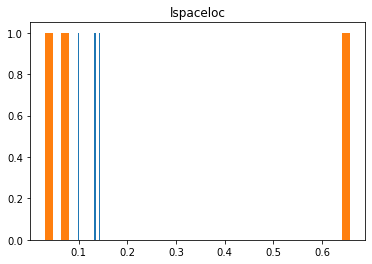

lspaceloc


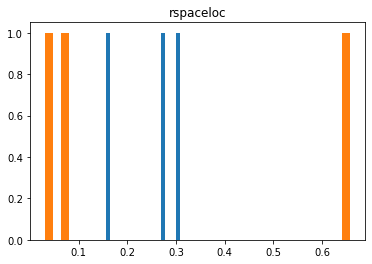

rspaceloc


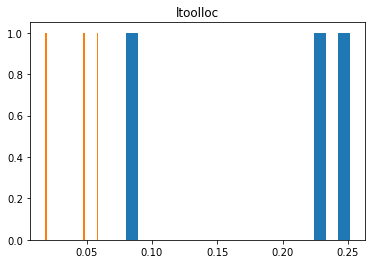

ltoolloc


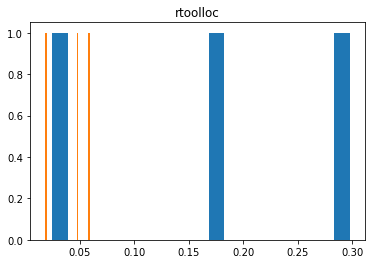

rtoolloc


In [27]:
for exp in exps:
    for lr in ['l','r']:
        plt.title(f'{lr}{exp}')
        plt.hist(control_summary[f'{lr}{exp}'], rwidth = .5)
        plt.hist(patient_summary[exp], 20, rwidth = .5)
        plt.pause(0.0001)
        print(f'{lr}{exp}')
        

spaceloc


KeyboardInterrupt: 

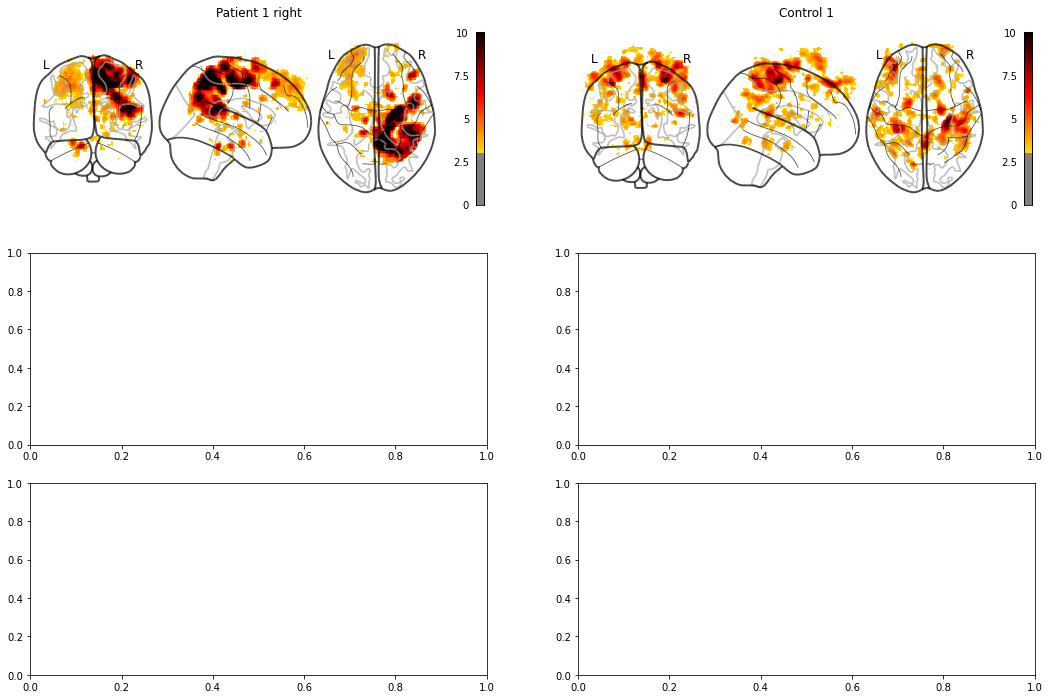

In [39]:

cond = 'spaceloc'

for ee in exps:
    fig, axes = plt.subplots(nrows=len(p_subs), ncols=2, figsize=(18, 12))
    print(ee)
    for axn in range(0,axes.shape[0]):
        #plot patient on lefthand side
        p_dir = f'{control_dir}/sub-{p_subs[axn]}/ses-01/derivatives/'
        p_stat = image.load_img(f'{p_dir}/fsl/{ee}/HighLevel{suf}.gfeat/cope1.feat/stats/zstat1.nii.gz')
        display = plotting.plot_glass_brain(p_stat, axes=axes[axn,0], threshold = 3.1, draw_cross = False, colorbar = True, vmin = 3.1,vmax = 10)
        axes[axn,0].title.set_text(f'Patient {axn + 1} {p_hemi[axn]}')

        #plot control on righthand side
        c_dir = f'{control_dir}/sub-{c_subs[axn]}/ses-01/derivatives/'
        c_stat = image.load_img(f'{c_dir}/fsl/{ee}/HighLevel{suf}.gfeat/cope1.feat/stats/zstat1.nii.gz')
        display = plotting.plot_glass_brain(c_stat, axes=axes[axn,1], threshold = 3.1, draw_cross = False, colorbar = True, vmin = 3.1,vmax = 10)
        axes[axn,1].title.set_text(f'Control {axn + 1}')

    plt.show()
    plt.pause(0.001)

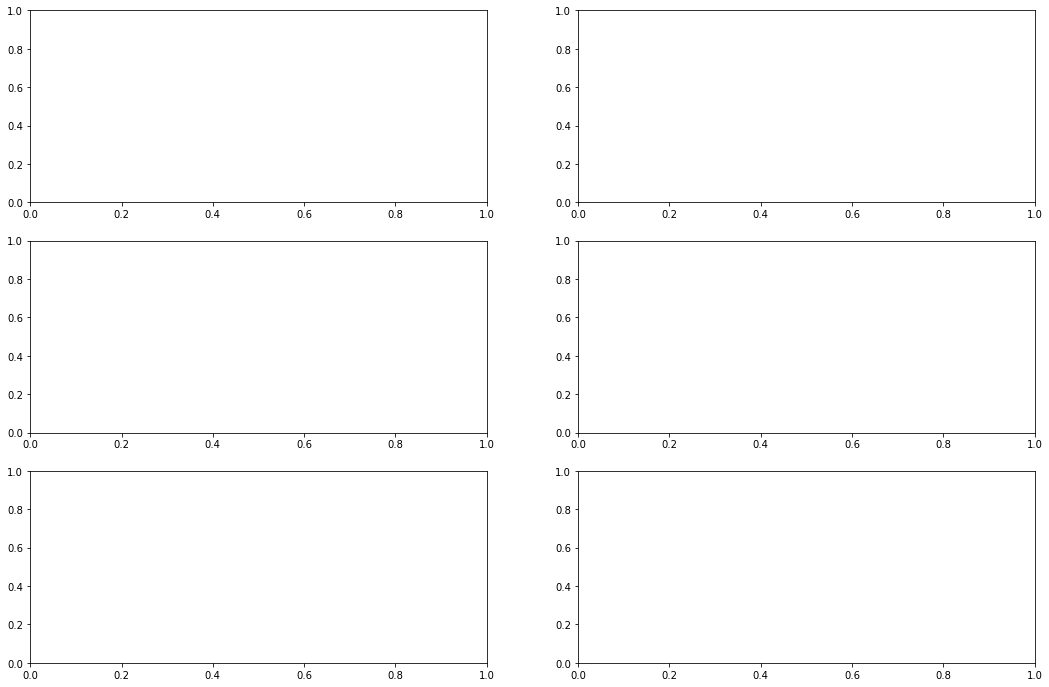

In [32]:
fig, axes = plt.subplots(nrows=len(p_subs), ncols=2, figsize=(18, 12))

In [34]:
axes.shape[0]

3

In [253]:
df_summary.mean()

lspaceloc    0.272156
ltoolloc     0.059526
rspaceloc    0.167944
rtoolloc     0.060327
dtype: float64

In [94]:
f'{stat_dir}/stats/zstat1.nii.gz'

'/lab_data/behrmannlab/vlad/hemispace/sub-hemispace1001/ses-01/derivatives//fsl/toolloc/HighLevel_roi.gfeat/cope1.feat//stats/zstat1.nii.gz'

In [62]:
anat_np = image.get_data(anat)
mid = list((np.array((anat_np.shape))/2).astype(int))
anat_np[anat_np>0] = 1
anat_np[mid[0]:, :, :] = 0 
rh_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image
print(mid)

[64, 80, 80]


In [71]:
anat_np[anat_np>0] = 1
anat_np[mid[0]:, :, :] = 0 
rh_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image


In [ ]:
hemi_mask

In [77]:
anat_np = image.get_data(anat)
anat_test = nib.Nifti1Image(anat_np, affine)  # create the volume image